# Banks — Customer segmentation by product consumption and outflow

<b> Project: </b>
One of the best banks in the country needs to analyze customer churn and segment users of the bank's products in order to develop a strategy for interacting with customers based on analytical data.

<b> Data provided: </b>
CSV file "bank_dataset.csv" containing data about the bank's customers. The Bank is located in Yaroslavl and the regional cities of Rostov Veliky and Rybinsk.

<b> Tasks: </b>
    Analysis of regional bank customers and segmentation of users by the number of products consumed.
1. Conducting research data analysis;
2. Segmentation of users based on data on the number of products consumed;
3. Formulation and verification of statistical hypotheses.
    
<b> Research results: </b>
Formulation of the main conclusions and development of recommendations for improving the quality of work with clients:
1. Formulation of conclusions based on the results of hypothesis testing;
2. Allocation of client segments; 
3. Development of measures to reduce outflow.

## Data Preparation and Exploration

In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import scipy
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)

In [362]:
bank = pd.read_csv('/Users/vintera/Git/my_projects/dataset/project_11/bank_dataset.csv')

In [363]:
bank.sample(10, random_state = 0)
bank.info()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9394,15658489,597,Ростов Великий,Ж,35,8,131101.04,1,1,1,192852.67,0
898,15697436,523,Ярославль,Ж,40,2,102967.41,1,1,0,128702.10,1
2398,15676613,706,Рыбинск,Ж,42,8,95386.82,1,1,1,75732.25,0
5906,15788359,788,Ярославль,М,32,4,112079.58,1,0,0,89368.59,0
2343,15808638,706,Ростов Великий,М,38,5,163034.82,2,1,1,135662.17,0
8225,15846878,670,Рыбинск,Ж,57,3,175575.95,2,1,0,99061.75,1
5506,15739764,590,Рыбинск,М,34,0,65812.35,2,0,1,160346.30,0
6451,15765319,636,Рыбинск,Ж,29,6,157576.47,2,1,1,101102.39,0
2670,15803182,598,Ярославль,Ж,64,9,NaN,1,0,1,13181.37,1
3497,15631680,456,Ярославль,Ж,63,1,165350.61,2,0,0,140758.07,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [364]:
bank.describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


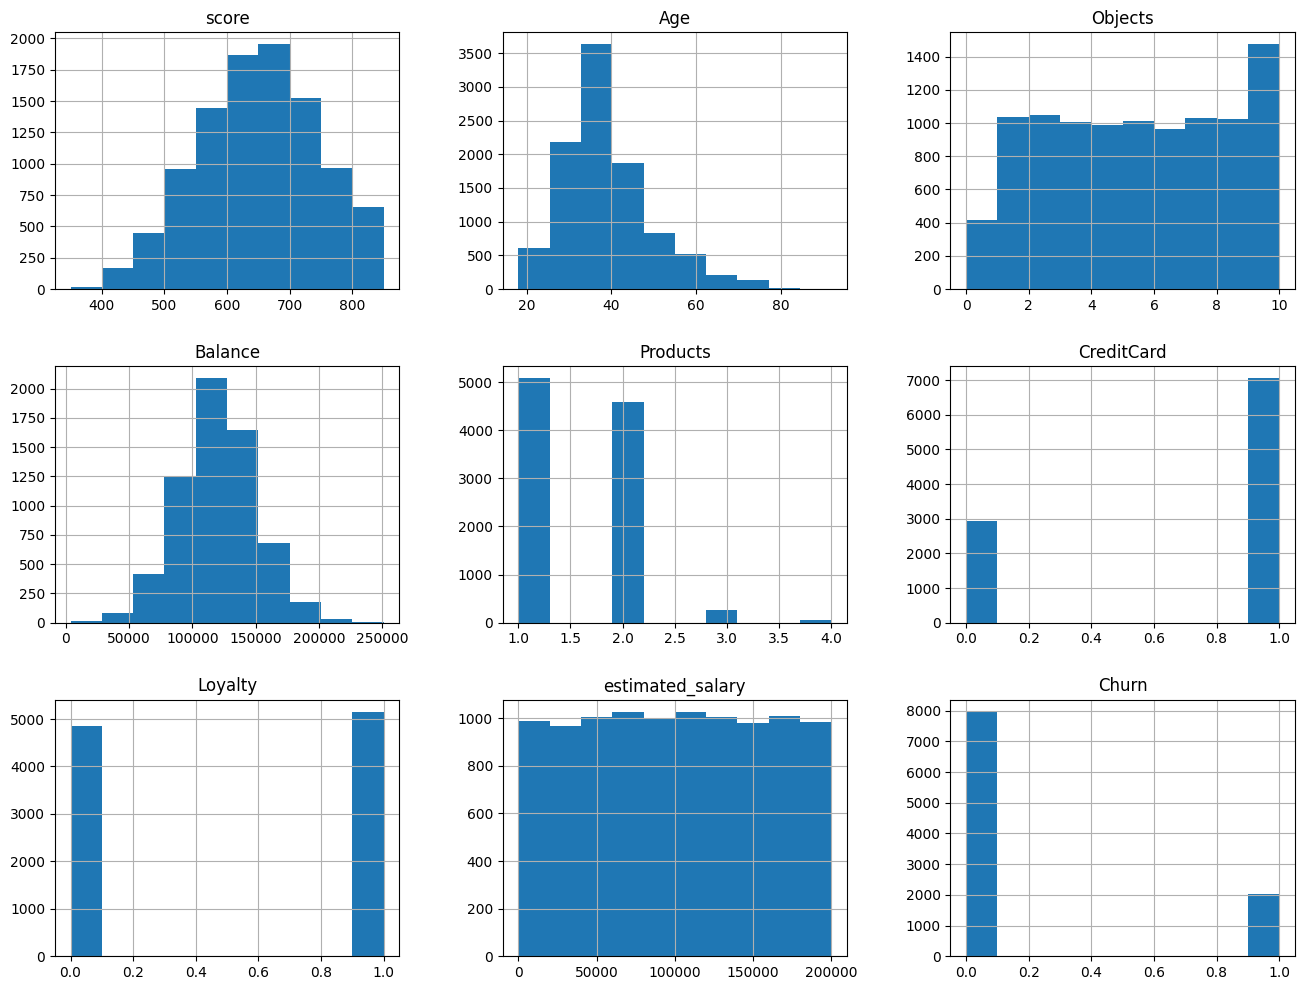

In [365]:
bank.drop('userid', axis=1).hist(figsize= (16,12));

### Summary

For research, we have a table consisting of 10,000 rows and 12 columns containing information about the Bank's customers. There are 3617 empty cells in the Balance column (we will study the nature of their appearance in the future), the data types correspond to the values contained. At first glance, there are no abnormal values. For convenience, you can bring the column names to a single sample.

## Data preprocessing and research

In [366]:
# For convenience, we will bring the column names to a single sample
bank.columns = bank.columns.str.lower()
bank = bank.rename(columns={'creditcard' : 'credit_card'})

In [367]:
# Check for duplicates
bank.duplicated().sum()

0

In [368]:
# For the convenience of further analysis, we will translate categorical data about the city and the field into fields with binary values
bank_without_categorical = pd.get_dummies(bank)

### Analyzing and working with gaps in balance data

In [369]:
# Check the average values of customer attributes with missing balance data
bank_without_categorical.query('balance.isna()').describe()

,userid,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,3.617000e+03,3617.000000,3617.000000,3617.000000,0.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.0,3617.000000,3617.000000,3617.000000,3617.000000
mean,1.573469e+07,649.452861,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236,0.0,0.331490,0.668510,0.457285,0.542715
std,7.194749e+04,96.158798,10.492002,2.860781,NaN,0.496455,0.450704,0.499751,57730.828955,0.345195,0.0,0.470814,0.470814,0.498241,0.498241
min,1.560844e+07,350.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,90.070000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.567226e+07,583.000000,31.000000,3.000000,NaN,1.000000,0.000000,0.000000,49506.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.573608e+07,651.000000,37.000000,5.000000,NaN,2.000000,1.000000,1.000000,98618.790000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000
75%,1.579629e+07,717.000000,43.000000,7.000000,NaN,2.000000,1.000000,1.000000,148330.970000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,1.585810e+07,850.000000,88.000000,10.000000,NaN,4.000000,1.000000,1.000000,199992.480000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


#### Comment
The average values of clients with omissions in the balance have no striking features, there are no anomalies that could be paid attention to. You can only pay attention to the fact that in Rostov Veliky all customers have information about the balance, but more than half of Yaroslavl customers do not have information about the balance in the questionnaire.

In [370]:
# Create a table, excluding rows with omissions from it
filled_bank = bank_without_categorical.query('balance.notnull()')

In [371]:
# Compare the values of the tables
bank_without_categorical.describe().round(2)
filled_bank.describe().round(2)

,userid,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,10000.00,10000.00,10000.00,10000.00,6383.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.00,10000.00,10000.0,10000.00,10000.00
mean,15733676.57,650.53,38.92,5.01,119827.49,1.53,0.71,0.52,100090.24,0.2,0.25,0.25,0.5,0.45,0.55
std,71936.19,96.65,10.49,2.89,30095.06,0.58,0.46,0.50,57510.49,0.4,0.43,0.43,0.5,0.50,0.50
min,15608437.00,350.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.0,0.00,0.00,0.0,0.00,0.00
25%,15671264.25,584.00,32.00,3.00,100181.98,1.00,0.00,0.00,51002.11,0.0,0.00,0.00,0.0,0.00,0.00
50%,15733474.00,652.00,37.00,5.00,119839.69,1.00,1.00,1.00,100193.92,0.0,0.00,0.00,1.0,0.00,1.00
75%,15795969.75,718.00,44.00,7.00,139512.29,2.00,1.00,1.00,149388.25,0.0,1.00,0.00,1.0,1.00,1.00
max,15858426.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.00,1.00,1.0,1.00,1.00


,userid,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,6383.00,6383.00,6383.00,6383.00,6383.00,6383.00,6383.00,6383.00,6383.00,6383.00,6383.00,6383.0,6383.00,6383.00,6383.00
mean,15733104.80,651.14,39.20,4.98,119827.49,1.39,0.70,0.51,100717.35,0.24,0.39,0.2,0.41,0.45,0.55
std,71929.13,96.93,10.48,2.91,30095.06,0.58,0.46,0.50,57380.32,0.43,0.49,0.4,0.49,0.50,0.50
min,15608437.00,350.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.00,0.00,0.0,0.00,0.00,0.00
25%,15670940.00,584.00,32.00,2.00,100181.98,1.00,0.00,0.00,51736.85,0.00,0.00,0.0,0.00,0.00,0.00
50%,15732262.00,652.00,38.00,5.00,119839.69,1.00,1.00,1.00,101139.30,0.00,0.00,0.0,0.00,0.00,1.00
75%,15795842.00,718.00,44.00,8.00,139512.29,2.00,1.00,1.00,149596.62,0.00,1.00,0.0,1.00,1.00,1.00
max,15858426.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199970.74,1.00,1.00,1.0,1.00,1.00,1.00


#### Comment
The averages and medians of the two tables are almost the same.

<AxesSubplot: title={'center': 'score'}, ylabel='Frequency'>

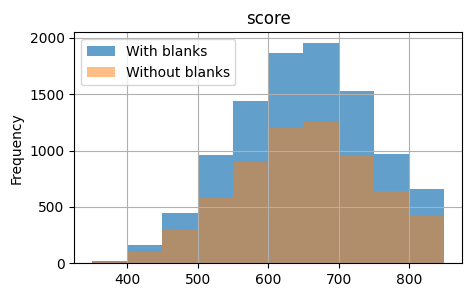

<AxesSubplot: title={'center': 'age'}, ylabel='Frequency'>

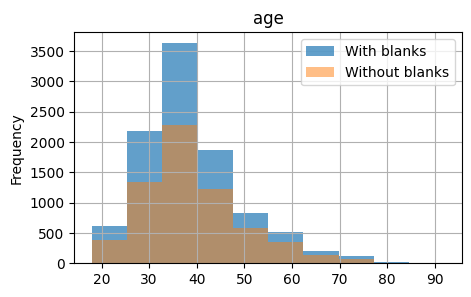

<AxesSubplot: title={'center': 'objects'}, ylabel='Frequency'>

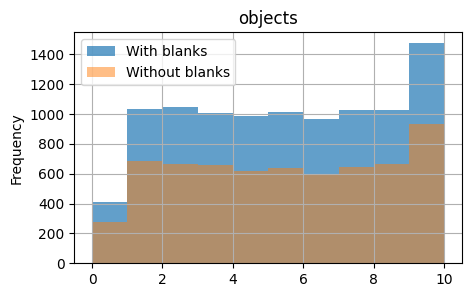

<AxesSubplot: title={'center': 'products'}, ylabel='Frequency'>

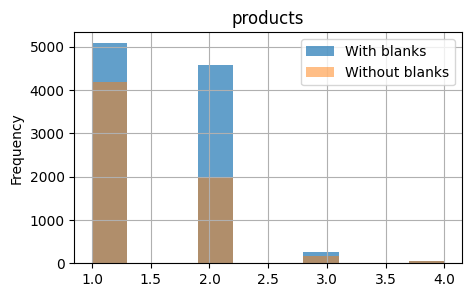

<AxesSubplot: title={'center': 'credit_card'}, ylabel='Frequency'>

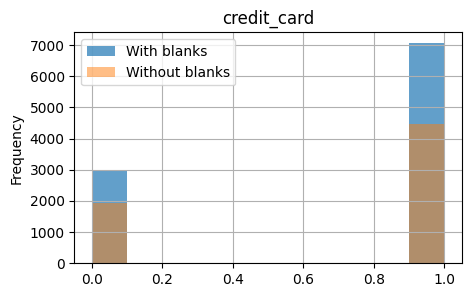

<AxesSubplot: title={'center': 'loyalty'}, ylabel='Frequency'>

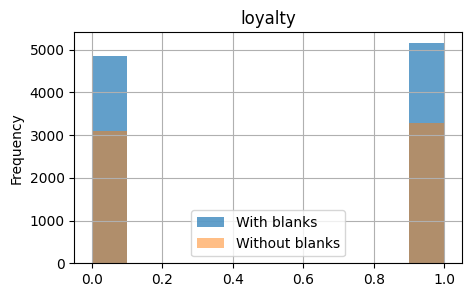

<AxesSubplot: title={'center': 'estimated_salary'}, ylabel='Frequency'>

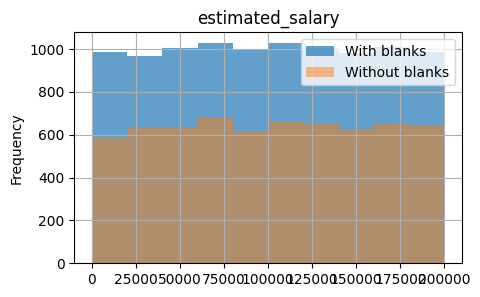

<AxesSubplot: title={'center': 'churn'}, ylabel='Frequency'>

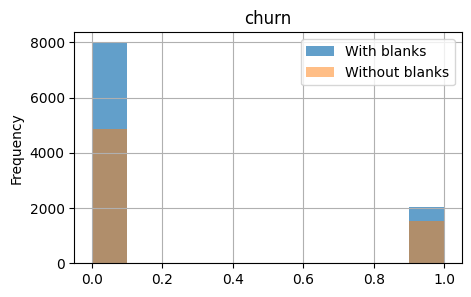

In [372]:
# Plot the distribution of numerical values for two tables
for col in bank.select_dtypes(include=np.number).drop(['userid', 'balance'], axis=1).columns:
    ax = bank.plot(kind='hist', y=col, 
    alpha=0.7, label='With blanks', figsize = (5,3), title=col)
    filled_bank.plot(kind='hist', y=col,
    alpha=0.5, label='Without blanks', ax=ax, grid=True, legend=True)
    plt.show();

#### Comment
Visually, the data in the two tables are distributed proportionally to each other. Abnormal values or exceptional features inherent in a particular dataframe were not detected.

#### Summary

Comparing the data of customers who do not have information about the balance with the data of all customers, we did not notice significant differences in their distribution. From this, it can be concluded that customers with a missing balance are not a certain category of customers (at least based on the available features) with exceptional features or features inherent in them. In order to avoid data distortion, we will not fill in the gaps with any values, and if necessary, we will use a sample of 6383 rows with filled data. Despite this, it can be assumed that employees of offices located in Yaroslavl have problems with collecting information about the client's balance. If this is true, then it is worth conducting appropriate classes for employees from Yaroslavl based on the experience of Rostov colleagues who have no problems with collecting information.

## Exploratory Data Analysis

### Customer churn analysis

In [373]:
bank.churn.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

#### Comment
remaining clients make up only a fifth of the entire sample (2037).

In [374]:
# Group by outflow and look at the average values
bank_without_categorical.drop('userid', axis=1).groupby('churn').mean().T.round(2)

churn,0,1
score,651.85,645.35
age,37.41,44.84
objects,5.03,4.93
balance,119535.86,120746.97
products,1.54,1.48
credit_card,0.71,0.70
loyalty,0.55,0.36
estimated_salary,99738.39,101465.68
city_Ростов Великий,0.21,0.40
city_Рыбинск,0.26,0.20


#### Comment
Of the obvious differences between the two groups, we can note the average age of the remaining - 45 years to 37 years for the remaining and the activity of the remaining - 0.36 to 0.55 for the remaining users. Also, customers from Rostov Veliky get into the outflow more often than customers from other cities. The other signs have no significant differences.

<AxesSubplot: title={'center': 'score'}, ylabel='Frequency'>

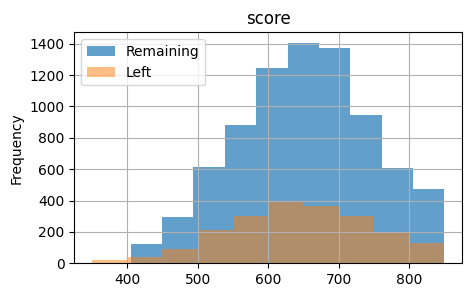

<AxesSubplot: title={'center': 'age'}, ylabel='Frequency'>

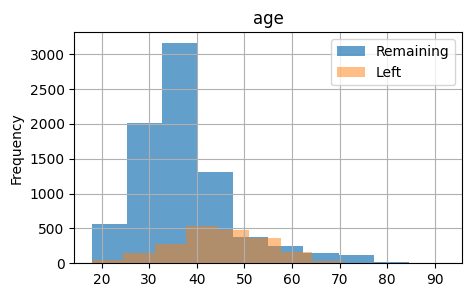

<AxesSubplot: title={'center': 'objects'}, ylabel='Frequency'>

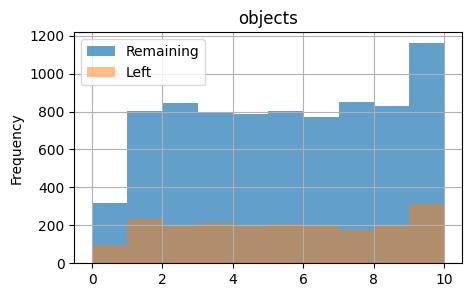

<AxesSubplot: title={'center': 'balance'}, ylabel='Frequency'>

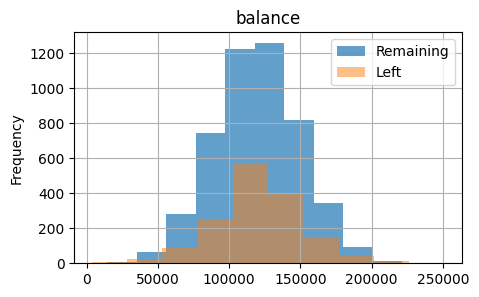

<AxesSubplot: title={'center': 'products'}, ylabel='Frequency'>

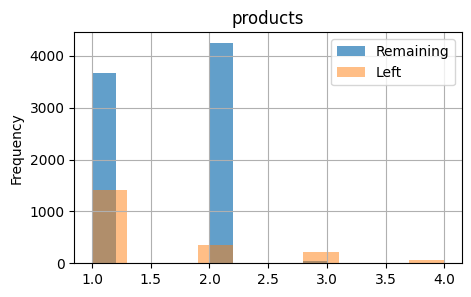

<AxesSubplot: title={'center': 'credit_card'}, ylabel='Frequency'>

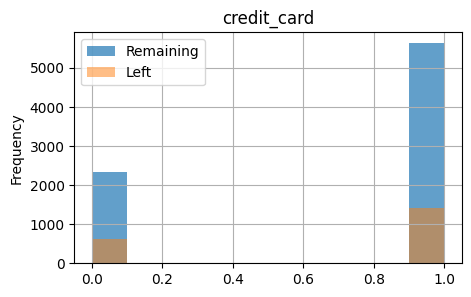

<AxesSubplot: title={'center': 'loyalty'}, ylabel='Frequency'>

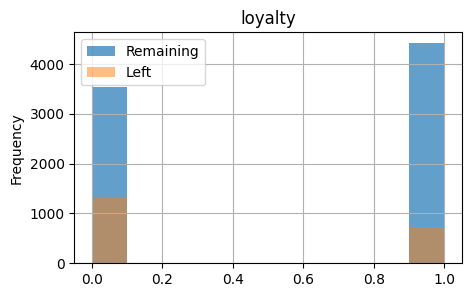

<AxesSubplot: title={'center': 'estimated_salary'}, ylabel='Frequency'>

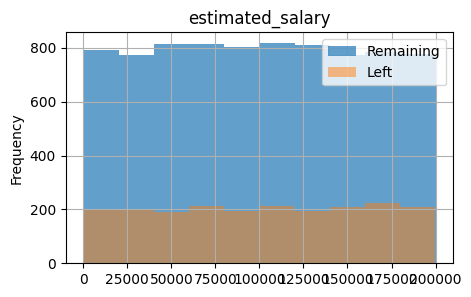

In [375]:
# In the loop, we will run the names of the columns (signs) and for each we will build graphs for the remaining and the remaining
for col in bank.select_dtypes(include=np.number).drop(['userid', 'churn'], axis=1).columns:
    ax = bank.query('churn == 0').plot(kind='hist', y=col, 
    alpha=0.7, label='Remaining', figsize = (5,3), title=col)
    bank.query('churn == 1').plot(kind='hist', y=col,
    alpha=0.5, label='Left', ax=ax, grid=True, legend=True)
    plt.show();

#### Comment
On the charts, in addition to the differences between the two groups already listed earlier, you can also pay attention to the fact that those who left more often used three products of the bank and they exclusively used four products, although the vast majority of them used one product, unlike the customers who stayed.

### Analysis of customer consumption of products

In [376]:
bank.products.value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

#### Comment
3 and 4 products are used by extremely few customers at the same time. Customers using the 1st and 2nd products were divided almost equally - 5084 and 4590, respectively.

In [377]:
# Group by the number of products used and look at the average values
bank_without_categorical.drop('userid', axis=1).groupby('products').mean().T.round(2)

products,1,2,3,4
score,649.12,652.19,648.11,653.58
age,39.67,37.75,43.20,45.68
objects,4.97,5.05,5.00,5.30
balance,119894.16,119660.94,119475.69,122260.61
credit_card,0.70,0.71,0.71,0.68
loyalty,0.50,0.53,0.42,0.48
estimated_salary,99487.26,100452.01,104318.13,104763.72
churn,0.28,0.08,0.83,1.00
city_Ростов Великий,0.27,0.23,0.36,0.40
city_Рыбинск,0.24,0.26,0.25,0.12


#### Comment
Grouping the data by the number of products consumed, perhaps we can pay attention to the older age of those who use 3 and 4 products (43 and 46 years, respectively), less activity and a higher outflow of these two groups.

<AxesSubplot: title={'center': 'score'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'score'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'score'}, ylabel='Frequency'>

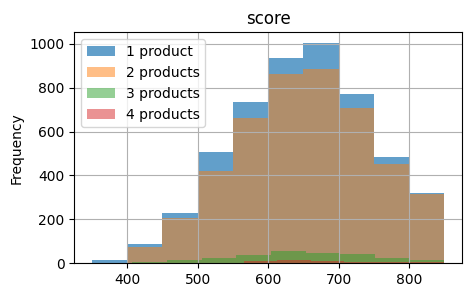

<AxesSubplot: title={'center': 'age'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'age'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'age'}, ylabel='Frequency'>

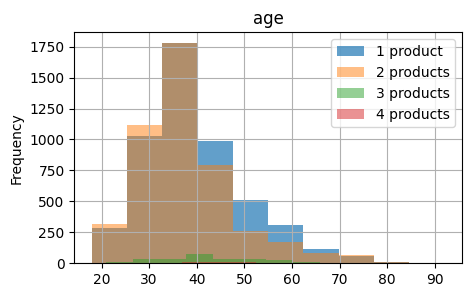

<AxesSubplot: title={'center': 'objects'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'objects'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'objects'}, ylabel='Frequency'>

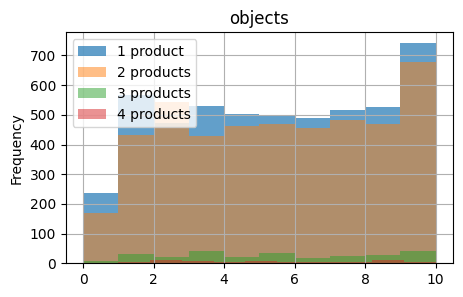

<AxesSubplot: title={'center': 'balance'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'balance'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'balance'}, ylabel='Frequency'>

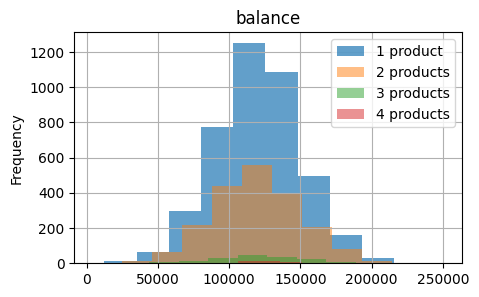

<AxesSubplot: title={'center': 'products'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'products'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'products'}, ylabel='Frequency'>

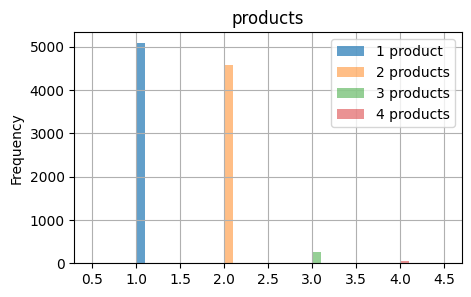

<AxesSubplot: title={'center': 'credit_card'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'credit_card'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'credit_card'}, ylabel='Frequency'>

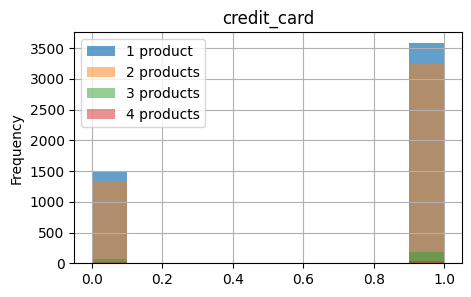

<AxesSubplot: title={'center': 'loyalty'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'loyalty'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'loyalty'}, ylabel='Frequency'>

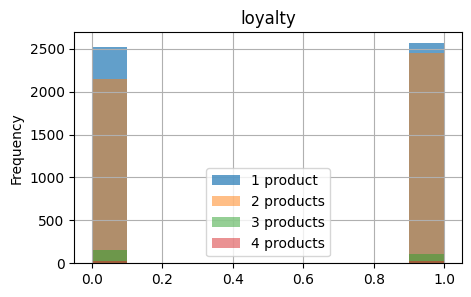

<AxesSubplot: title={'center': 'estimated_salary'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'estimated_salary'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'estimated_salary'}, ylabel='Frequency'>

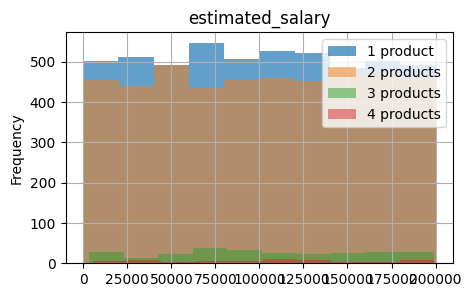

<AxesSubplot: title={'center': 'churn'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'churn'}, ylabel='Frequency'>

<AxesSubplot: title={'center': 'churn'}, ylabel='Frequency'>

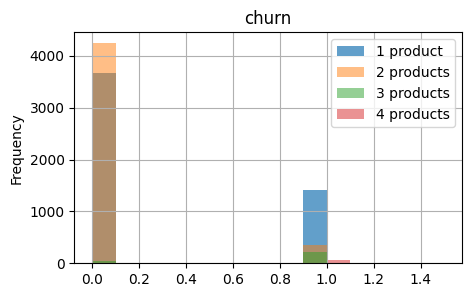

In [378]:
# # Similarly, we will build graphs based on user attributes depending on the number of products
for col in bank.select_dtypes(include=np.number).drop('userid', axis=1).columns:
    ax = bank.query('products == 1').plot(kind='hist', y=col, 
    alpha=0.7, label='1 product', figsize = (5,3), title=col)
    bank.query('products == 2').plot(kind='hist', y=col,
    alpha=0.5, label='2 products', ax=ax, grid=True, legend=True)
    bank.query('products == 3').plot(kind='hist', y=col,
    alpha=0.5, label='3 products', ax=ax, grid=True, legend=True)
    bank.query('products == 4').plot(kind='hist', y=col,
    alpha=0.5, label='4 products', ax=ax, grid=True, legend=True)
    plt.show();

#### Comment
Visualization of the results obtained earlier also reveals signs that differ between groups. Probably the main thing to pay attention to is the older age and the outflow of customers who used 3 and 4 products at the same time.

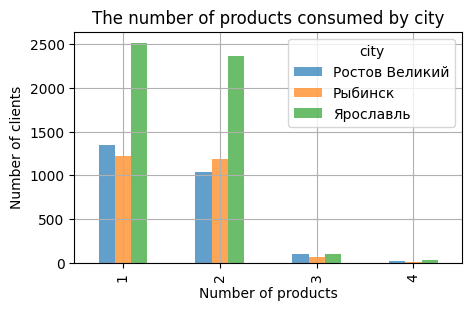

In [379]:
city_products = bank.pivot_table(index='products', columns='city', values='userid', aggfunc='count').reset_index()
city_products.plot(kind="bar",x='products', stacked=False, grid=True, figsize=(5, 3), alpha=0.7)

plt.title('The number of products consumed by city')
plt.xlabel('Number of products')
plt.ylabel('Number of clients');

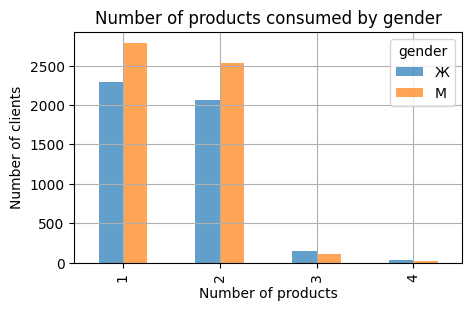

In [380]:
gender_products = bank.pivot_table(index='products', columns= 'gender', values='userid', aggfunc='count').reset_index()
gender_products.plot(kind="bar",x='products', stacked=False, grid=True, figsize=(5, 3), alpha=0.7)

plt.title('Number of products consumed by gender')
plt.xlabel('Number of products')
plt.ylabel('Number of clients');

### Correlation of features

In [381]:
# Build a correlation matrix
cm = bank.corr()

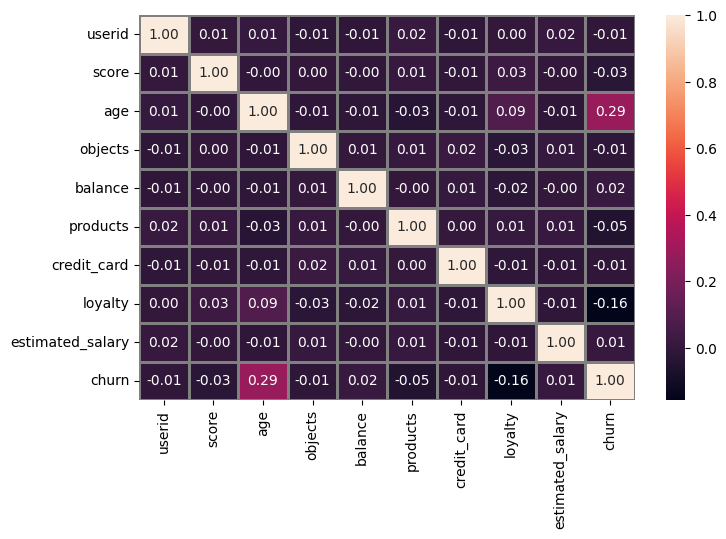

In [382]:
# Visualize a heat map with captions for the correlation matrix
fig = plt.subplots(figsize=(8,5)) 
sns.heatmap(cm, annot = True, fmt='.2f', linewidths=1, linecolor='gray')

plt.show();

#### Summary
Unfortunately, there are no obvious signs correlating with the outflow of customers or the number of products used on the matrix. Among all weak dependencies, the age trait (0.29) turned out to be the leader in interaction with outflow.

In [383]:
phikcm = bank.drop('userid', axis=1).phik_matrix()

interval columns not set, guessing: ['score', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn']


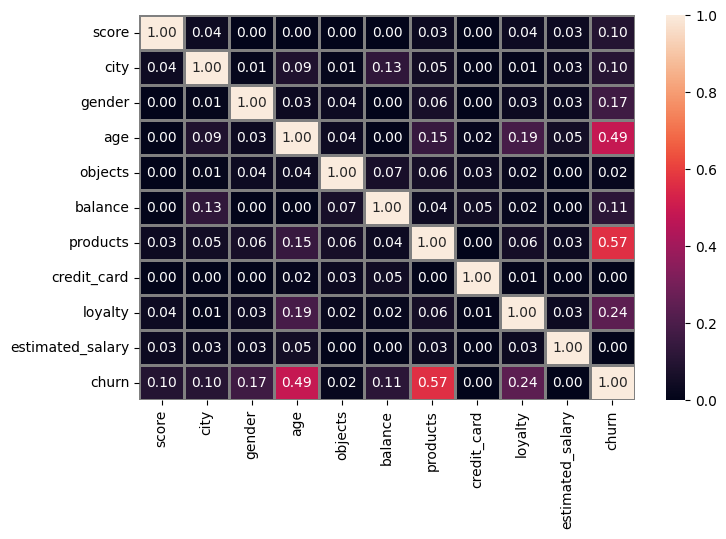

In [384]:
fig = plt.subplots(figsize=(8,5)) 
sns.heatmap(phikcm, annot = True, fmt='.2f', linewidths=1, linecolor='gray')

plt.show();

### Summary

After conducting an exploratory analysis of the basic properties of the data, we were convinced of the absence of abnormal values, the normal distribution of data, and also established some weak patterns in them, thanks to which it is possible to form the first hypotheses and build preliminary forecasts on the predisposition to outflow and the choice of a certain number of products for some groups of customers.

## Segmentation of customers by the number of products used

### Construction of the distance matrix and its visualization

In [385]:
# In the table, without omissions, we will present categorical data about a field and a city with a set of binary fields
copy_filled_bank = pd.get_dummies(filled_bank)
copy_filled_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6383 entries, 1 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   userid               6383 non-null   int64  
 1   score                6383 non-null   int64  
 2   age                  6383 non-null   int64  
 3   objects              6383 non-null   int64  
 4   balance              6383 non-null   float64
 5   products             6383 non-null   int64  
 6   credit_card          6383 non-null   int64  
 7   loyalty              6383 non-null   int64  
 8   estimated_salary     6383 non-null   float64
 9   churn                6383 non-null   int64  
 10  city_Ростов Великий  6383 non-null   uint8  
 11  city_Рыбинск         6383 non-null   uint8  
 12  city_Ярославль       6383 non-null   uint8  
 13  gender_Ж             6383 non-null   uint8  
 14  gender_М             6383 non-null   uint8  
dtypes: float64(2), int64(8), uint8(5)
memo

In [386]:
# Remove the target variable
X = copy_filled_bank.drop('products', axis=1)

In [387]:
# Standardizing data
sc = StandardScaler()
X_sc = sc.fit_transform(X)
# Create a table of links between objects
linked = linkage(X_sc, method = 'ward') 

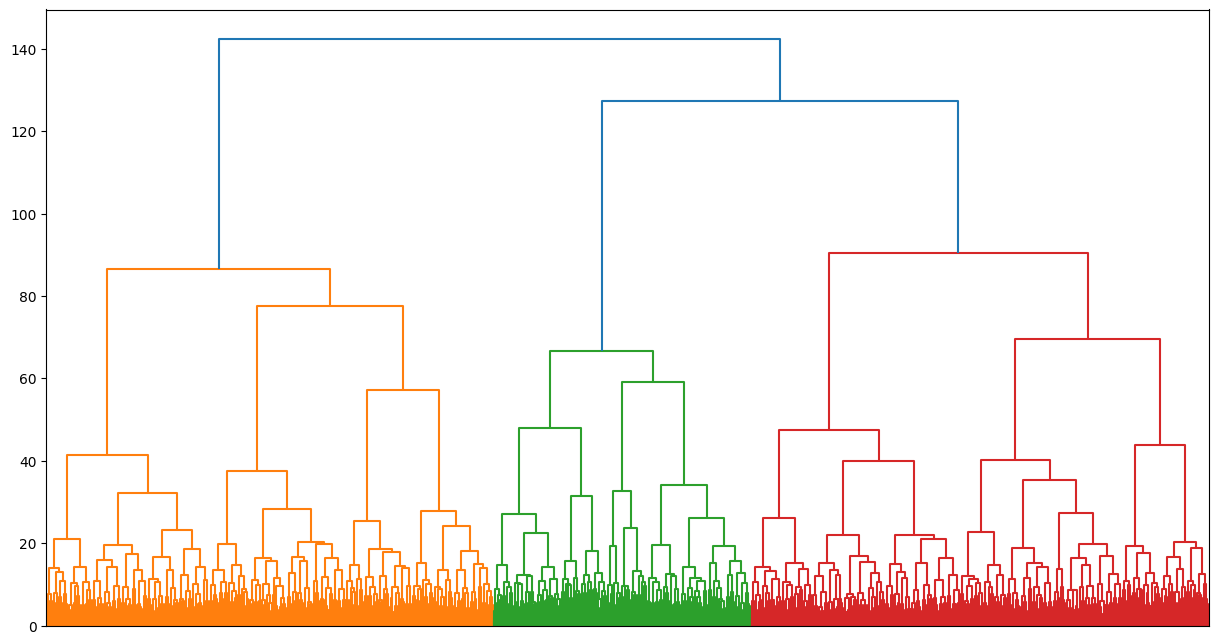

In [388]:
# Build a dendrogram
plt.figure(figsize=(15, 8))  
dendrogram(linked, orientation='top', no_labels=True)
plt.show();

#### Summary
Based on the visualization of agglomerative clustering, we obtain the optimal number of clusters proposed by the algorithm - 3. This number of clusters is proposed to the KMeans algorithm.

### Clustering based on the K-Means algorithm

In [389]:
# Setting the k_means model with the number of clusters equal to 3
km = KMeans(n_clusters = 3, random_state=0)
# Predicting clusters for observations
labels = km.fit_predict(X_sc)

In [390]:
# Create a column in the table with the assigned cluster number and group the data by it, getting their average values
copy_filled_bank['cluster'] = labels
bank_grouped_by_cluster = copy_filled_bank.groupby('cluster').mean().reset_index()
bank_grouped_by_cluster.drop(['cluster', 'userid'], axis=1).T.round(2)

,0,1,2
score,651.45,650.90,651.00
age,39.77,38.61,39.26
objects,5.01,4.95,4.98
balance,119730.12,119927.77,119814.99
products,1.52,1.30,1.30
credit_card,0.71,0.69,0.68
loyalty,0.50,0.51,0.55
estimated_salary,101113.44,100625.03,100127.28
churn,0.32,0.18,0.20
city_Ростов Великий,1.00,0.00,0.00


<AxesSubplot: title={'center': 'score'}>

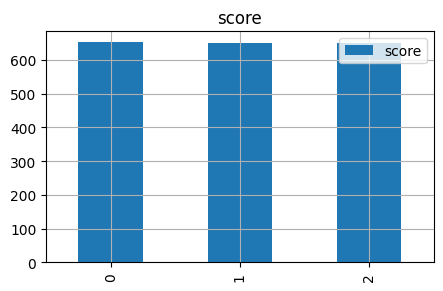

<AxesSubplot: title={'center': 'age'}>

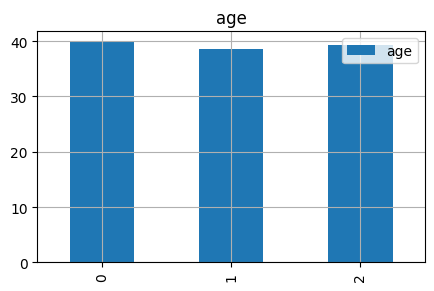

<AxesSubplot: title={'center': 'objects'}>

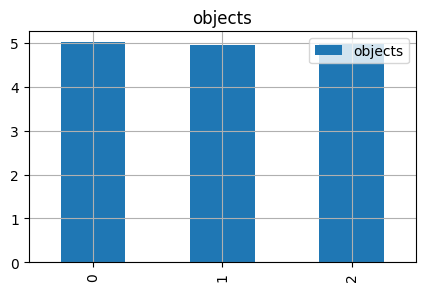

<AxesSubplot: title={'center': 'balance'}>

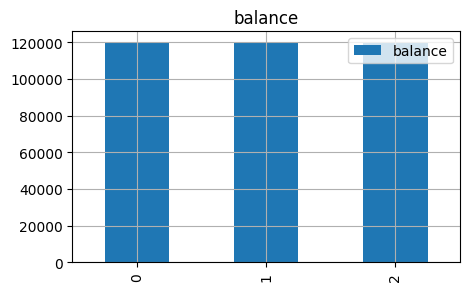

<AxesSubplot: title={'center': 'products'}>

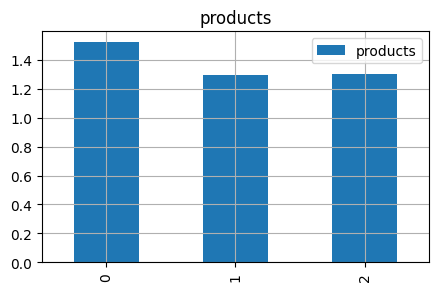

<AxesSubplot: title={'center': 'credit_card'}>

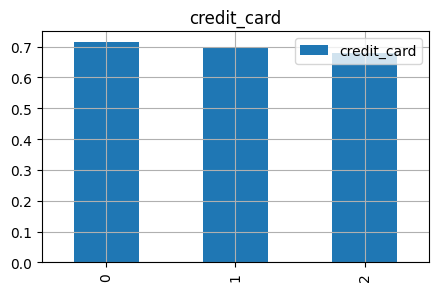

<AxesSubplot: title={'center': 'loyalty'}>

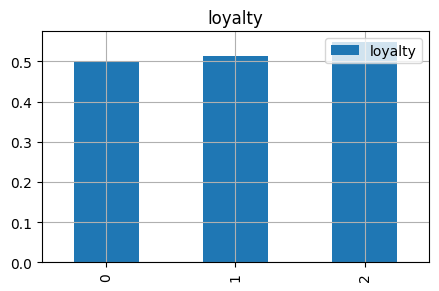

<AxesSubplot: title={'center': 'estimated_salary'}>

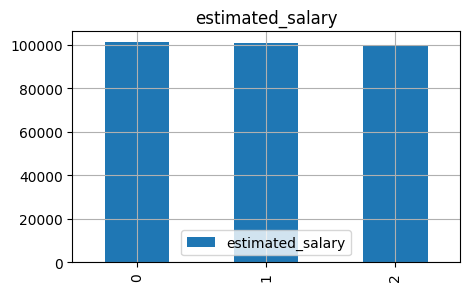

<AxesSubplot: title={'center': 'churn'}>

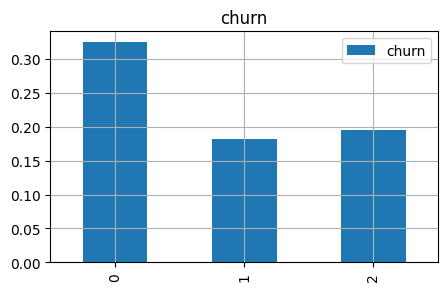

<AxesSubplot: title={'center': 'city_Ростов Великий'}>

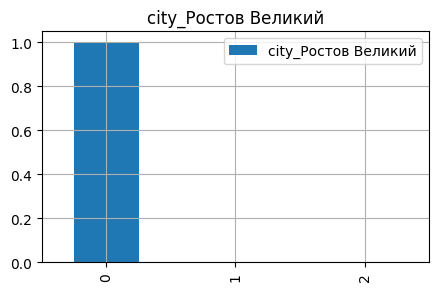

<AxesSubplot: title={'center': 'city_Рыбинск'}>

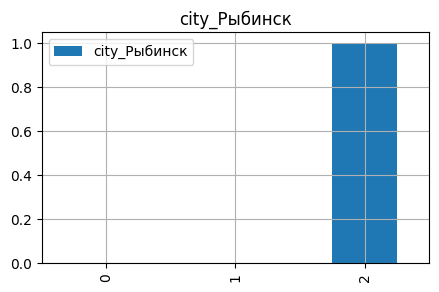

<AxesSubplot: title={'center': 'city_Ярославль'}>

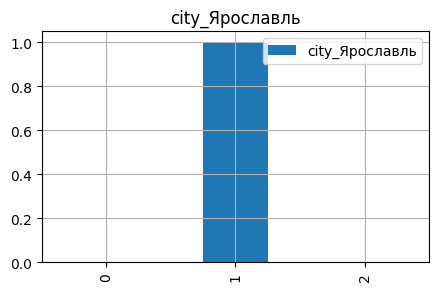

<AxesSubplot: title={'center': 'gender_Ж'}>

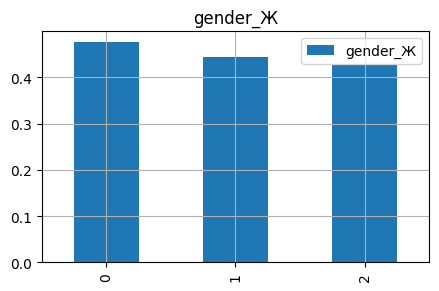

<AxesSubplot: title={'center': 'gender_М'}>

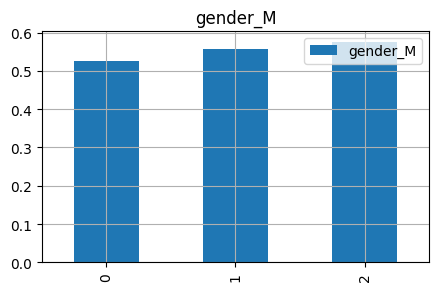

In [391]:
# In the loop, we will build graphs for all features with clustering
for col in bank_grouped_by_cluster.drop(['cluster', 'userid'], axis=1).columns:
    bank_grouped_by_cluster.plot.bar(y=col, figsize = (5,3), title=col, grid=True)
    plt.show()

#### Summary
Visualization of cluster indicators demonstrated the absence of obvious differences between the groups obtained using the k_means algorithm. On average, customers use the same number of banking products.

### Summary

As it was revealed earlier, at the stage of research data analysis, clients from the presented sample do not have pronounced differences. Neither working "manually" by grouping data, nor clustering using the K_means algorithm allowed us to identify the features inherent in a particular group of clients, which once again confirmed the correctness of the low indicators of the feature correlation matrix. A slight relationship can be traced only among the older group of customers who use a large number of products, while showing less activity and more often falls into the outflow. Let's try, based on this information, to form appropriate hypotheses.

## Hypothesis testing

In [392]:
def shapiro_test(sample_1, sample_2):
    
    p_value_1 = st.shapiro(sample_1)[1]
    p_value_2 = st.shapiro(sample_2)[1]

    alpha = 0.05
    
    print('Selection 1')
    print('p-value: ', p_value_1)
    if p_value_1 < alpha:
        print('Reject the null hypothesis: the distribution is not normal')
    else:
        print('Not possible to reject the null hypothesis, everything is fine') 
    print('-------------------------------------------------------')
    print('Selection 2')
    print('p-value: ', p_value_2)
    if p_value_2 < alpha:
        print('Reject the null hypothesis: the distribution is not normal')
    else:
        print('Not possible to reject the null hypothesis, everything is fine') 

### Comment
Let's create a data validation function for normality using the Shapiro-Wilk criterion. For convenience, we will check two samples at once.

### Hypothesis 1: "The incomes of customers who use two bank products and the incomes of customers who use one are different."

h₀ - The income of customers who use two products of the bank, and the income of customers who use one do not differ.

h₁ - The income of customers who use two products of the bank, and the income of customers who use one are different.

In [393]:
# Create samples to compare the salaries of customers with one and two products
one_product = bank.query('products == 1')['estimated_salary']
two_products = bank.query('products == 2')['estimated_salary']

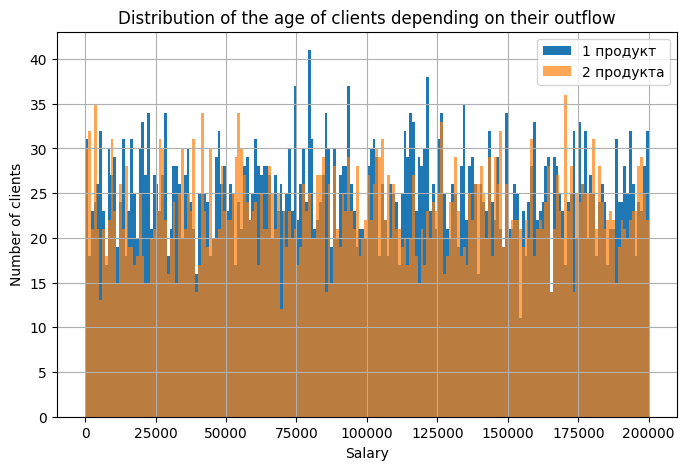

In [394]:
# Visualize the distribution of data in the specified samples
one_product.plot(kind='hist', bins=200, label='1 продукт', figsize = (8,5), legend=True)
two_products.plot(kind='hist',bins=200, alpha=0.7, label='2 продукта', grid=True, legend=True)

plt.title('Distribution of the age of clients depending on their outflow')
plt.xlabel('Salary')
plt.ylabel('Number of clients');
plt.show();

In [395]:
shapiro_test(one_product, two_products)

Selection 1
p-value:  3.016880709638032e-36
Reject the null hypothesis: the distribution is not normal
-------------------------------------------------------
Selection 2
p-value:  2.1693455518781312e-35
Reject the null hypothesis: the distribution is not normal


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Comment
The conducted verification found that the data are distributed abnormally, and therefore, for comparison of samples, we use the nonparametric Wilcoxon-Mann-Whitney test.

In [396]:
alpha = 0.05

results = st.mannwhitneyu(one_product, two_products)
print('average income of customers using one product: {:.0f}'.format(one_product.mean()))
print('average income of customers using two products: {:.0f}'.format(two_products.mean()))
print()
print('p-value: {:.10f}'.format(results.pvalue))
print()
if alpha > results.pvalue:
    print('Reject the null hypothesis: the difference is statistically significant')
else:
    print('Not possible to reject the null hypothesis, it is impossible to draw a conclusion about the difference')

average income of customers using one product: 99487
average income of customers using two products: 100452

p-value: 0.4079566652

Not possible to reject the null hypothesis, it is impossible to draw a conclusion about the difference


#### Summary
p-value is above the critical level of statistical significance, which tells us that there are no statistically significant differences in the two populations, and therefore it is not possible to reject the null hypothesis. The incomes of customers who use two products of the bank and the incomes of customers who use one do not differ.

### Hypothesis 2: "The average age of the remaining clients and the remaining ones is different."

H₀ - The average age of the remaining and remaining customers does not differ.

H₁ - The average age of the remaining and remaining customers has differences.

In [397]:
remaining_client_age = bank.query('churn == 0')['age']
churn_client_age = bank.query('churn == 1')['age']

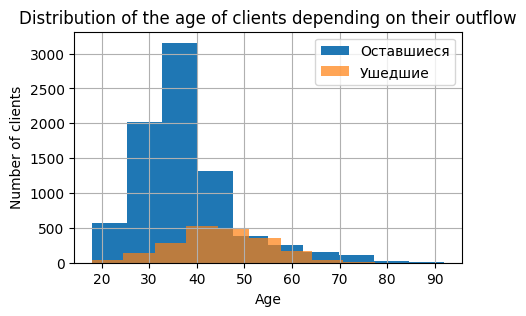

In [398]:
ax = remaining_client_age.plot(kind='hist', label='Оставшиеся', figsize = (5,3), legend=True)
churn_client_age.plot(kind='hist',alpha=0.7, label='Ушедшие', ax=ax, grid=True, legend=True)

plt.title('Distribution of the age of clients depending on their outflow')
plt.xlabel('Age')
plt.ylabel('Number of clients');
plt.show();

In [399]:
shapiro_test(remaining_client_age, churn_client_age)

Selection 1
p-value:  0.0
Reject the null hypothesis: the distribution is not normal
-------------------------------------------------------
Selection 2
p-value:  0.005863629747182131
Reject the null hypothesis: the distribution is not normal


In [400]:
alpha = 0.05
results = st.mannwhitneyu(remaining_client_age, churn_client_age)

print('average age of active clients: {:.0f}'.format(remaining_client_age.mean()))
print('average age of remaining clients: {:.0f}'.format(churn_client_age.mean()))
print()
print('p-value: {:.10f}'.format(results.pvalue))
print()
if alpha > results.pvalue:
    print('Reject the null hypothesis: the difference is statistically significant')
else:
    print('Not possible to reject the null hypothesis, it is impossible to draw a conclusion about the difference')

average age of active clients: 37
average age of departed clients: 45

p-value: 0.0000000000

Reject the null hypothesis: the difference is statistically significant


#### Summary
p-the value is below the critical level of statistical significance, which tells us that there are differences in the two populations, and therefore, the null hypothesis is rejected. The average age of the remaining clients is 45, the remaining ones are 37 (the difference is noticeable).

### Summary

Having checked the hypotheses put forward before the study, we draw the following conclusions:
   - The incomes of customers who use two products of the bank and the incomes of customers who use one do not differ;
   - The average age of current and remaining clients varies. The outflow includes clients with an average age of 45 years, when the average age of the current client is 37 years.

## General Conclusion and Recommendations

<b>1. Segmentation by product consumption:</b>

<b> - Features inherent to customers with 1 product (51%):</b>
In half of the cases - customers from Yaroslavl, on average 39-40 years old, in 70% - with a credit card, only about a quarter of them got into the outflow;

<b> - Features inherent to customers with 2 products (46%):</b>
In half of the cases - clients from Yaroslavl, on average 37-38 years old, in 70% - having a credit card, are the most active clients with the lowest number of outflows - 7.6%;

<b> - Signs inherent in customers with 3-4 products (3%):</b>
A little more often, these are women (56% and 63%, respectively, products), almost equally from Yaroslavl and Rostov the Great, have the highest incomes, low activity and a huge outflow (83% and 100%), compared with other segments.
__________________________________________________________________________________________________________________
<b>2. Segmentation by outflow:</b>

<b> - Signs inherent in loyal customers:</b>
Men from Yaroslavl, on average 38-40 years old, using 2 banking products, are more loyal customers.

<b> - Signs inherent in remaining clients:</b>
Women with an average age of 43-45 years from Rostov Veliky, who used 3-4 products of the Bank, showing lower customer activity, more often than others go into outflow.

__________________________________________________________________________________________________________________
<b>3.Recommendations for business:</b>
1. For further research, there is a need to collect more detailed information about:
    - clients of the bank (place of work (study), position, marital status, education, how long has been a client, what products have been used and are currently using during this time, when applying for loans - loan amounts and goals);
    - banking products (a more detailed disclosure of each product is required for a qualitative analysis of customer interaction with them and the impact of a certain set of products on outflow).
2. Perhaps in Yaroslavl there are problems with collecting information about the balance of customers, it is necessary to understand the reasons for a large number of omissions.
3. Analysis using more data on customer activity and interaction with the Bank's products in Rostov Veliky, where outflow is higher than in other cities.
4. It is necessary to study the products used by the remaining customers. Analysis of feedback from remaining customers will help in this matter.
5. Increase in marketing costs for attracting groups of citizens over 40 years of age, as well as existing customers, with falling user activity.
6. Revision or implementation of the cashback program, with an increased rate for the purchase of goods and services in demand among women and customers over 40 years old (customers prone to outflow).